## Multilabel topic classification

For given question title or question description, predict all possible topics of the question to be tagged. 


Data is scrapped from https://leetcode.com/problemset/all/


#### Previous approach

In the previous classification, model was trained across all the topics (total 71). The major Challenge, the is highly imbalance which can reduce overall accuracy of the model.

#### Current approach

Classifier needs to be designed in such a way that it tries to predict only one label at a time. (One Vs rest classfier)

for this experiment, I will select top 10 topics, and will try to predict topics. 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_10666/229677857.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## 1. EDA

In [2]:
data = pd.read_csv('data/all_questions_data.csv')

In [3]:
data.head(2)

,Question Title,Question Slug,Question ID,Question Text,Topic Tagged text,Topic Tagged ID,Difficulty Level,Success Rate,total submission,total accepted,company tag,Likes,Dislikes,Hints,Similar Questions ID,Similar Questions Text
0,Minimum Interval to Include Each Query,minimum-interval-to-include-each-query,1977,"You are given a 2D integer array intervals, wh...","Array,Binary Search,Line Sweep,Sorting,Heap (P...","VG9waWNUYWdOb2RlOjU=,VG9waWNUYWdOb2RlOjEx,VG9w...",Hard,45.5,14492,6599,NaN,336,6,Is there a way to order the intervals and quer...,NaN,NaN
1,Distinct Numbers in Each Subarray,distinct-numbers-in-each-subarray,2003,NaN,"Array,Hash Table,Sliding Window","VG9waWNUYWdOb2RlOjU=,VG9waWNUYWdOb2RlOjY=,VG9w...",Medium,72.6,5116,3712,NaN,73,3,Keep a frequency map of the elements in each w...,NaN,NaN


In [4]:
# for the current classification problem, I only required text and topics columns

data = data[['Question ID', 'Question Title', 'Question Text', 'Topic Tagged text']]
data

,Question ID,Question Title,Question Text,Topic Tagged text
0,1977,Minimum Interval to Include Each Query,"You are given a 2D integer array intervals, wh...","Array,Binary Search,Line Sweep,Sorting,Heap (P..."
1,2003,Distinct Numbers in Each Subarray,NaN,"Array,Hash Table,Sliding Window"
2,2004,Convert Date Format,NaN,Database
3,1983,Maximum Population Year,You are given a 2D integer array logs where ea...,"Array,Counting"
4,1984,Maximum Distance Between a Pair of Values,You are given two non-increasing 0-indexed int...,"Array,Two Pointers,Binary Search,Greedy"
...,...,...,...,...
2233,876,Hand of Straights,Alice has some number of cards and she wants t...,"Array,Hash Table,Greedy,Sorting"
2234,877,Shortest Path Visiting All Nodes,"You have an undirected, connected graph of n n...","Dynamic Programming,Bit Manipulation,Breadth-F..."
2235,878,Shifting Letters,You are given a string s of lowercase English ...,"Array,String"
2236,879,Maximize Distance to Closest Person,You are given an array representing a row of s...,Array


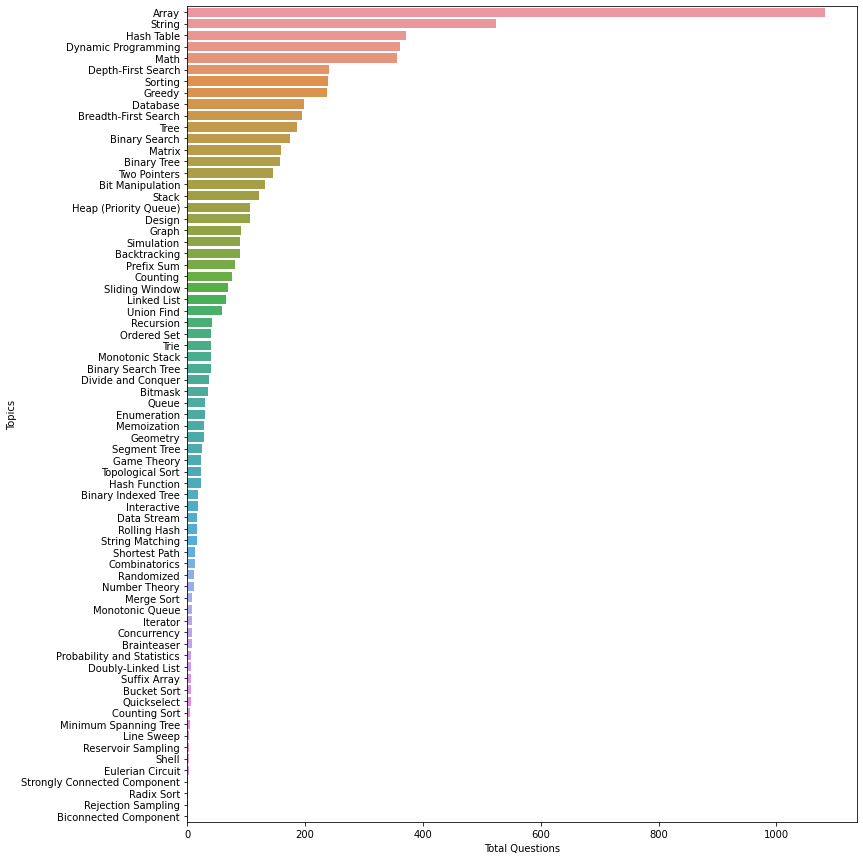

In [5]:
# Total number of quetions in each topics

# Generate questions stats
topics_count = {}

for _, que in data[['Topic Tagged text']].iterrows():
    
    if type(que['Topic Tagged text']) != str:
        continue
        
    topics_lst = que['Topic Tagged text'].split(',')
    
    for topic in topics_lst:
        # Topic count
        if topic not in list(topics_count.keys()):
            topics_count[topic] = 1
        else:
            topics_count[topic] = topics_count[topic] + 1

# create dataframe
tc_df = pd.DataFrame(pd.Series(topics_count)).reset_index()
tc_df.columns = ['Topics', 'Total Questions']
tc_df.sort_values(by=['Total Questions'], ascending=False, inplace=True)
tc_df.reset_index(drop=True, inplace=True)

# Plot 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=tc_df, x= "Total Questions", y = "Topics") 
ax.set(ylabel = 'Topics') 
plt.show()

##### As we can see the data is highly imbalance. So for rest of the processing, I will consider first 10 topics to predict. 

###### In a iterative way, I will integrate rest of the topics.

## 2. Transform data

In [6]:
# first 10 labels

labels = list(tc_df[:10]['Topics'])
main_labels = labels
labels

['Array',
 'String',
 'Hash Table',
 'Dynamic Programming',
 'Math',
 'Depth-First Search',
 'Sorting',
 'Greedy',
 'Database',
 'Breadth-First Search']

In [7]:
# check for null values

data.isnull().sum()

Question ID            0
Question Title         0
Question Text        480
Topic Tagged text      2
dtype: int64

In [8]:
# two instances has not any labels, we can totally remove them.

data = data.dropna(subset=['Topic Tagged text'])

data.isnull().sum()

Question ID            0
Question Title         0
Question Text        478
Topic Tagged text      0
dtype: int64

In [9]:
# create new dataframe

def _initiallize_label_stats(labels):
    stats = {}
    for label in labels:
        stats[label] = 0
    return stats

df = pd.DataFrame()

for _, row in data.iterrows():
    q_dict = {}
    q_dict['id'] = row['Question ID']
    q_dict['title'] = row['Question Title']
    q_dict['desc'] = row['Question Text']
    
    row_labels = row['Topic Tagged text'].split(',')
    
    target_labels = _initiallize_label_stats(labels)
    
    # filter question who has labels from target labels
    if any(label in row_labels for label in target_labels):
        
        for label in labels:
            if label in row_labels:
                target_labels[label] = 1

        # merge both dictionaries
        q_dict.update(target_labels)

        q_df = pd.DataFrame.from_dict(q_dict, orient='index').transpose()
        df = df.append(q_df)
    
df.reset_index(drop=True, inplace=True)

In [10]:
df.shape

(2126, 13)

In [11]:
df

,id,title,desc,Array,String,Hash Table,Dynamic Programming,Math,Depth-First Search,Sorting,Greedy,Database,Breadth-First Search
0,1977,Minimum Interval to Include Each Query,"You are given a 2D integer array intervals, wh...",1,0,0,0,0,0,1,0,0,0
1,2003,Distinct Numbers in Each Subarray,NaN,1,0,1,0,0,0,0,0,0,0
2,2004,Convert Date Format,NaN,0,0,0,0,0,0,0,0,1,0
3,1983,Maximum Population Year,You are given a 2D integer array logs where ea...,1,0,0,0,0,0,0,0,0,0
4,1984,Maximum Distance Between a Pair of Values,You are given two non-increasing 0-indexed int...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,876,Hand of Straights,Alice has some number of cards and she wants t...,1,0,1,0,0,0,1,1,0,0
2122,877,Shortest Path Visiting All Nodes,"You have an undirected, connected graph of n n...",0,0,0,1,0,0,0,0,0,1
2123,878,Shifting Letters,You are given a string s of lowercase English ...,1,1,0,0,0,0,0,0,0,0
2124,879,Maximize Distance to Closest Person,You are given an array representing a row of s...,1,0,0,0,0,0,0,0,0,0


In [12]:
df.tail(5)

,id,title,desc,Array,String,Hash Table,Dynamic Programming,Math,Depth-First Search,Sorting,Greedy,Database,Breadth-First Search
2121,876,Hand of Straights,Alice has some number of cards and she wants t...,1,0,1,0,0,0,1,1,0,0
2122,877,Shortest Path Visiting All Nodes,"You have an undirected, connected graph of n n...",0,0,0,1,0,0,0,0,0,1
2123,878,Shifting Letters,You are given a string s of lowercase English ...,1,1,0,0,0,0,0,0,0,0
2124,879,Maximize Distance to Closest Person,You are given an array representing a row of s...,1,0,0,0,0,0,0,0,0,0
2125,880,Rectangle Area II,You are given a 2D array of axis-aligned recta...,1,0,0,0,0,0,0,0,0,0


In [13]:
df[main_labels] = df[main_labels].astype(int)

### 2.1 Plot questions with multiple topics

In [14]:
row_sums = df.iloc[:, 3:].sum(axis=1)

multilabel_counts = row_sums.value_counts()
multilabel_counts = multilabel_counts.iloc[1:]

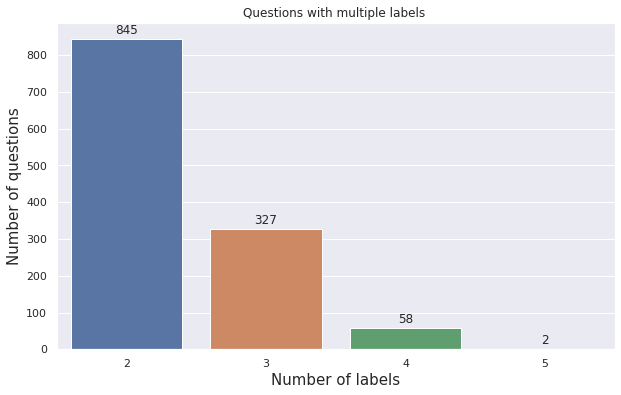

In [15]:
# plot 
sns.set(font_scale = 1)
plt.figure(figsize=(10,6))

ax = sns.barplot(multilabel_counts.index, multilabel_counts.values)

plt.title("Questions with multiple labels ")
plt.ylabel('Number of questions', fontsize=15)
plt.xlabel('Number of labels', fontsize=15)

#adding the text labels
rects = ax.patches
labels = multilabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

### 2.2 Preprocess texts

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
import re

In [17]:
# helper functions to process texts

def remove_html(text):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(text))
    return cleantext

def remove_spe_char(text):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',text)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',text)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def text_only(text):
    alpha_sent = ""
    for word in text.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

In [18]:
# process texts

df['title'] = df['title'].str.lower()
df['title'] = df['title'].apply(remove_html)
df['title'] = df['title'].apply(remove_spe_char)
df['title'] = df['title'].apply(text_only)


df['desc'] = df['desc'].str.lower()
df['desc'] = df['desc'].apply(remove_html)
df['desc'] = df['desc'].apply(remove_spe_char)
df['desc'] = df['desc'].apply(text_only)

df.tail()

,id,title,desc,Array,String,Hash Table,Dynamic Programming,Math,Depth-First Search,Sorting,Greedy,Database,Breadth-First Search
2121,876,hand of straights,alice has some number of cards and she wants t...,1,0,1,0,0,0,1,1,0,0
2122,877,shortest path visiting all nodes,you have an undirected connected graph of n no...,0,0,0,1,0,0,0,0,0,1
2123,878,shifting letters,you are given a string s of lowercase english ...,1,1,0,0,0,0,0,0,0,0
2124,879,maximize distance to closest person,you are given an array representing a row of s...,1,0,0,0,0,0,0,0,0,0
2125,880,rectangle area ii,you are given a d array of axis aligned recta...,1,0,0,0,0,0,0,0,0,0


In [19]:
# nltk.download('stopwords')

In [20]:
# remove stopwords

stop_words = set(stopwords.words('english'))

re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def remove_stopwords(text):
    global re_stop_words
    return re_stop_words.sub(" ", text)

df['title'] = df['title'].apply(remove_stopwords)
df['desc'] = df['desc'].apply(remove_stopwords)

df.tail()

,id,title,desc,Array,String,Hash Table,Dynamic Programming,Math,Depth-First Search,Sorting,Greedy,Database,Breadth-First Search
2121,876,hand straights,alice number cards wants rearrange card...,1,0,1,0,0,0,1,1,0,0
2122,877,shortest path visiting nodes,undirected connected graph n nodes labeled...,0,0,0,1,0,0,0,0,0,1
2123,878,shifting letters,given string lowercase english letters ...,1,1,0,0,0,0,0,0,0,0
2124,879,maximize distance closest person,given array representing row seats seats...,1,0,0,0,0,0,0,0,0,0
2125,880,rectangle area ii,given array axis aligned rectangles rec...,1,0,0,0,0,0,0,0,0,0


In [21]:
## apply stemming - reduce words to their root forms

stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

df['title'] = df['title'].apply(stemming)
df['desc'] = df['desc'].apply(stemming)

df.tail()

,id,title,desc,Array,String,Hash Table,Dynamic Programming,Math,Depth-First Search,Sorting,Greedy,Database,Breadth-First Search
2121,876,hand straight,alic number card want rearrang card group grou...,1,0,1,0,0,0,1,1,0,0
2122,877,shortest path visit node,undirect connect graph n node label n given ar...,0,0,0,1,0,0,0,0,0,1
2123,878,shift letter,given string lowercas english letter integ arr...,1,1,0,0,0,0,0,0,0,0
2124,879,maxim distanc closest person,given array repres row seat seat repres person...,1,0,0,0,0,0,0,0,0,0
2125,880,rectangl area ii,given array axi align rectangl rectangl xi yi ...,1,0,0,0,0,0,0,0,0,0


## 3. Train-test split

In [22]:
from sklearn.model_selection import train_test_split

train, test= train_test_split(df, random_state=42, test_size = 0.2, shuffle=True)

print('train: ',train.shape, 'test: ', test.shape)

train:  (1700, 13) test:  (426, 13)


In [23]:
# final merging of title & desc
train['text'] = train['title'] + train['desc']
test['text'] = test['title'] + test['desc']

train.tail(5)

,id,title,desc,Array,String,Hash Table,Dynamic Programming,Math,Depth-First Search,Sorting,Greedy,Database,Breadth-First Search,text
1638,533,lone pixel ii,nan,1,0,1,0,0,0,0,0,0,0,lone pixel iinan
1095,1088,number day month,nan,0,0,0,0,1,0,0,0,0,0,number day monthnan
1130,1263,number dice roll target sum,n dice die k face number k given three integ n...,0,0,0,1,0,0,0,0,0,0,number dice roll target sumn dice die k face n...
1294,1406,subtract product sum digit integ,nan,0,0,0,0,1,0,0,0,0,0,subtract product sum digit integnan
860,904,leaf similar tree,consid leav binari tree left right order valu ...,0,0,0,0,0,1,0,0,0,0,leaf similar treeconsid leav binari tree left ...


## 4. Text feature extraction

In [24]:
from sklearn.feature_extraction.text import  TfidfVectorizer

In [25]:
train_text = train['text']
test_text = test['text']

In [26]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2',max_df=1.0)
vectorizer.fit(train_text)

TfidfVectorizer(ngram_range=(1, 3), strip_accents='unicode')

In [27]:
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels=['id', 'title', 'desc', 'text'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test.drop(labels=['id', 'title', 'desc', 'text'], axis=1)

## 5. Train Model

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

In [29]:
model = Pipeline([
    ('clf', OneVsRestClassifier(LinearSVC(class_weight='balanced', random_state=0, tol=1e-1, C=8.385), n_jobs=-1)),
])

### 5.1 SVM

In [30]:
# Array
model_arr = Pipeline([
    ('clf', OneVsRestClassifier(LinearSVC(class_weight='balanced', random_state=0, tol=1e-1, C=8.385), n_jobs=-1)),
])
print(f"processing..")
model_arr.fit(x_train, y_train['Array'])


# String
model_str = Pipeline([
    ('clf', OneVsRestClassifier(LinearSVC(class_weight='balanced', random_state=0, tol=1e-1, C=8.385), n_jobs=-1)),
])
print(f"processing..")
model_str.fit(x_train, y_train['String'])


# Hash Table
model_ht = Pipeline([
    ('clf', OneVsRestClassifier(LinearSVC(class_weight='balanced', random_state=0, tol=1e-1, C=8.385), n_jobs=-1)),
])
print(f"processing..")
model_ht.fit(x_train, y_train['Hash Table'])


# Dynamic Programming
model_dp = Pipeline([
    ('clf', OneVsRestClassifier(LinearSVC(class_weight='balanced', random_state=0, tol=1e-1, C=8.385), n_jobs=-1)),
])
print(f"processing..")
model_dp.fit(x_train, y_train['Dynamic Programming'])


# Math
model_math = Pipeline([
    ('clf', OneVsRestClassifier(LinearSVC(class_weight='balanced', random_state=0, tol=1e-1, C=8.385), n_jobs=-1)),
])
print(f"processing..")
model_math.fit(x_train, y_train['Math'])


# Depth-First Search
model_dfs = Pipeline([
    ('clf', OneVsRestClassifier(LinearSVC(class_weight='balanced', random_state=0, tol=1e-1, C=8.385), n_jobs=-1)),
])
print(f"processing..")
model_dfs.fit(x_train, y_train['Depth-First Search'])


# Sorting
model_sorting = Pipeline([
    ('clf', OneVsRestClassifier(LinearSVC(class_weight='balanced', random_state=0, tol=1e-1, C=8.385), n_jobs=-1)),
])
print(f"processing..")
model_sorting.fit(x_train, y_train['Sorting'])


# Greedy
model_greedy = Pipeline([
    ('clf', OneVsRestClassifier(LinearSVC(class_weight='balanced', random_state=0, tol=1e-1, C=8.385), n_jobs=-1)),
])
print(f"processing..")
model_greedy.fit(x_train, y_train['Greedy'])


# Database
model_db = Pipeline([
    ('clf', OneVsRestClassifier(LinearSVC(class_weight='balanced', random_state=0, tol=1e-1, C=8.385), n_jobs=-1)),
])
print(f"processing..")
model_db.fit(x_train, y_train['Database'])


# Breadth-First Search
model_bfs = Pipeline([
    ('clf', OneVsRestClassifier(LinearSVC(class_weight='balanced', random_state=0, tol=1e-1, C=8.385), n_jobs=-1)),
])
print(f"processing..")
model_bfs.fit(x_train, y_train['Breadth-First Search'])


processing..
processing..
processing..
processing..
processing..
processing..
processing..
processing..
processing..
processing..


Pipeline(steps=[('clf',
                 OneVsRestClassifier(estimator=LinearSVC(C=8.385,
                                                         class_weight='balanced',
                                                         random_state=0,
                                                         tol=0.1),
                                     n_jobs=-1))])

In [31]:
pred_df = pd.DataFrame()

pred_df['Array'] = model_arr.predict(x_test)
pred_df['String'] = model_str.predict(x_test)
pred_df['Hash Table'] = model_ht.predict(x_test)
pred_df['Dynamic Programming'] = model_dp.predict(x_test)
pred_df['Math'] = model_math.predict(x_test)
pred_df['Depth-First Search'] = model_dfs.predict(x_test)
pred_df['Sorting'] = model_sorting.predict(x_test)
pred_df['Greedy'] = model_greedy.predict(x_test)
pred_df['Database'] = model_db.predict(x_test)
pred_df['Breadth-First Search'] = model_bfs.predict(x_test)

In [32]:
# Acc, F1 Score & Average precision
from sklearn.metrics import f1_score, average_precision_score

avg_acc = accuracy_score(pred_df, y_test)
f1 = np.mean(np.array(f1_score(y_true=y_test, y_pred=pred_df,average = None)))
avg_prec = average_precision_score(y_true=y_test, y_score=pred_df)

print('Avg Acc: ',avg_acc , '\nAvg F1 Score: ', f1, '\nAverage Precision: ', avg_prec)

Avg Acc:  0.3004694835680751 
Avg F1 Score:  0.5510229572228754 
Average Precision:  0.42854692982885495


### 5.2 Only Logistic Regression


In [33]:
from sklearn.linear_model import LogisticRegression

# Array
model_arr = LogisticRegression(C=12.0)
print(f"processing..")
model_arr.fit(x_train, y_train['Array'])


# String
model_str = LogisticRegression(C=12.0)
print(f"processing..")
model_str.fit(x_train, y_train['String'])


# Hash Table
model_ht = LogisticRegression(C=12.0)
print(f"processing..")
model_ht.fit(x_train, y_train['Hash Table'])


# Dynamic Programming
model_dp = LogisticRegression(C=12.0)
print(f"processing..")
model_dp.fit(x_train, y_train['Dynamic Programming'])


# Math
model_math = LogisticRegression(C=12.0)
print(f"processing..")
model_math.fit(x_train, y_train['Math'])


# Depth-First Search
model_dfs = LogisticRegression(C=12.0)
print(f"processing..")
model_dfs.fit(x_train, y_train['Depth-First Search'])


# Sorting
model_sorting = LogisticRegression(C=12.0)
print(f"processing..")
model_sorting.fit(x_train, y_train['Sorting'])


# Greedy
model_greedy = LogisticRegression(C=12.0)
print(f"processing..")
model_greedy.fit(x_train, y_train['Greedy'])


# Database
model_db = LogisticRegression(C=12.0)
print(f"processing..")
model_db.fit(x_train, y_train['Database'])


# Breadth-First Search
model_bfs = LogisticRegression(C=12.0)
print(f"processing..")
model_bfs.fit(x_train, y_train['Breadth-First Search'])


processing..
processing..
processing..
processing..
processing..
processing..
processing..
processing..
processing..
processing..


LogisticRegression(C=12.0)

In [34]:
new_res = pd.DataFrame()

new_res['Array'] = model_arr.predict(x_test)
new_res['String'] = model_str.predict(x_test)
new_res['Hash Table'] = model_ht.predict(x_test)
new_res['Dynamic Programming'] = model_dp.predict(x_test)
new_res['Math'] = model_math.predict(x_test)
new_res['Depth-First Search'] = model_dfs.predict(x_test)
new_res['Sorting'] = model_sorting.predict(x_test)
new_res['Greedy'] = model_greedy.predict(x_test)
new_res['Database'] = model_db.predict(x_test)
new_res['Breadth-First Search'] = model_bfs.predict(x_test)

In [35]:
# Acc, F1 Score & Average precision
from sklearn.metrics import f1_score, average_precision_score

avg_acc = accuracy_score(new_res, y_test)
f1 = np.mean(np.array(f1_score(y_true=y_test, y_pred=new_res,average = None)))
avg_prec = average_precision_score(y_true=y_test, y_score=new_res)

print('Avg Acc: ',avg_acc , '\nAvg F1 Score: ', f1, '\nAverage Precision: ', avg_prec)

Avg Acc:  0.2511737089201878 
Avg F1 Score:  0.4540449026194797 
Average Precision:  0.3768252998780576


### 5.3 DecisionTree

In [36]:
from sklearn.tree import DecisionTreeClassifier

# Array
model_arr = DecisionTreeClassifier(max_depth = 2)
print(f"processing..")
model_arr.fit(x_train, y_train['Array'])


# String
model_str = DecisionTreeClassifier(max_depth = 2)
print(f"processing..")
model_str.fit(x_train, y_train['String'])


# Hash Table
model_ht = DecisionTreeClassifier(max_depth = 2)
print(f"processing..")
model_ht.fit(x_train, y_train['Hash Table'])


# Dynamic Programming
model_dp = DecisionTreeClassifier(max_depth = 2)
print(f"processing..")
model_dp.fit(x_train, y_train['Dynamic Programming'])


# Math
model_math = DecisionTreeClassifier(max_depth = 2)
print(f"processing..")
model_math.fit(x_train, y_train['Math'])


# Depth-First Search
model_dfs = DecisionTreeClassifier(max_depth = 2)
print(f"processing..")
model_dfs.fit(x_train, y_train['Depth-First Search'])


# Sorting
model_sorting = DecisionTreeClassifier(max_depth = 2)
print(f"processing..")
model_sorting.fit(x_train, y_train['Sorting'])


# Greedy
model_greedy = DecisionTreeClassifier(max_depth = 2)
print(f"processing..")
model_greedy.fit(x_train, y_train['Greedy'])


# Database
model_db = DecisionTreeClassifier(max_depth = 2)
print(f"processing..")
model_db.fit(x_train, y_train['Database'])


# Breadth-First Search
model_bfs = DecisionTreeClassifier(max_depth = 2)
print(f"processing..")
model_bfs.fit(x_train, y_train['Breadth-First Search'])


processing..
processing..
processing..
processing..
processing..
processing..
processing..
processing..
processing..
processing..


DecisionTreeClassifier(max_depth=2)

In [37]:
new_res = pd.DataFrame()

new_res['Array'] = model_arr.predict(x_test)
new_res['String'] = model_str.predict(x_test)
new_res['Hash Table'] = model_ht.predict(x_test)
new_res['Dynamic Programming'] = model_dp.predict(x_test)
new_res['Math'] = model_math.predict(x_test)
new_res['Depth-First Search'] = model_dfs.predict(x_test)
new_res['Sorting'] = model_sorting.predict(x_test)
new_res['Greedy'] = model_greedy.predict(x_test)
new_res['Database'] = model_db.predict(x_test)
new_res['Breadth-First Search'] = model_bfs.predict(x_test)

In [38]:
# Acc, F1 Score & Average precision
from sklearn.metrics import f1_score, average_precision_score

avg_acc = accuracy_score(new_res, y_test)
f1 = np.mean(np.array(f1_score(y_true=y_test, y_pred=new_res,average = None)))
avg_prec = average_precision_score(y_true=y_test, y_score=new_res)

print('Avg Acc: ',avg_acc , '\nAvg F1 Score: ', f1, '\nAverage Precision: ', avg_prec)

Avg Acc:  0.2112676056338028 
Avg F1 Score:  0.3559260252340763 
Average Precision:  0.33843458181182234


### 5.4 kNN

In [39]:
from sklearn.neighbors import KNeighborsClassifier

# Array
model_arr = KNeighborsClassifier(n_neighbors = 7)
print(f"processing..")
model_arr.fit(x_train, y_train['Array'])


# String
model_str = KNeighborsClassifier(n_neighbors = 7)
print(f"processing..")
model_str.fit(x_train, y_train['String'])


# Hash Table
model_ht = KNeighborsClassifier(n_neighbors = 7)
print(f"processing..")
model_ht.fit(x_train, y_train['Hash Table'])


# Dynamic Programming
model_dp = KNeighborsClassifier(n_neighbors = 7)
print(f"processing..")
model_dp.fit(x_train, y_train['Dynamic Programming'])


# Math
model_math = KNeighborsClassifier(n_neighbors = 7)
print(f"processing..")
model_math.fit(x_train, y_train['Math'])


# Depth-First Search
model_dfs = KNeighborsClassifier(n_neighbors = 7)
print(f"processing..")
model_dfs.fit(x_train, y_train['Depth-First Search'])


# Sorting
model_sorting = KNeighborsClassifier(n_neighbors = 7)
print(f"processing..")
model_sorting.fit(x_train, y_train['Sorting'])


# Greedy
model_greedy = KNeighborsClassifier(n_neighbors = 7)
print(f"processing..")
model_greedy.fit(x_train, y_train['Greedy'])


# Database
model_db = KNeighborsClassifier(n_neighbors = 7)
print(f"processing..")
model_db.fit(x_train, y_train['Database'])


# Breadth-First Search
model_bfs = KNeighborsClassifier(n_neighbors = 7)
print(f"processing..")
model_bfs.fit(x_train, y_train['Breadth-First Search'])


processing..
processing..
processing..
processing..
processing..
processing..
processing..
processing..
processing..
processing..


KNeighborsClassifier(n_neighbors=7)

In [40]:
new_res = pd.DataFrame()

new_res['Array'] = model_arr.predict(x_test)
new_res['String'] = model_str.predict(x_test)
new_res['Hash Table'] = model_ht.predict(x_test)
new_res['Dynamic Programming'] = model_dp.predict(x_test)
new_res['Math'] = model_math.predict(x_test)
new_res['Depth-First Search'] = model_dfs.predict(x_test)
new_res['Sorting'] = model_sorting.predict(x_test)
new_res['Greedy'] = model_greedy.predict(x_test)
new_res['Database'] = model_db.predict(x_test)
new_res['Breadth-First Search'] = model_bfs.predict(x_test)

In [41]:
# Acc, F1 Score & Average precision
from sklearn.metrics import f1_score, average_precision_score

avg_acc = accuracy_score(new_res, y_test)
f1 = np.mean(np.array(f1_score(y_true=y_test, y_pred=new_res,average = None)))
avg_prec = average_precision_score(y_true=y_test, y_score=new_res)

print('Avg Acc: ',avg_acc , '\nAvg F1 Score: ', f1, '\nAverage Precision: ', avg_prec)

Avg Acc:  0.2300469483568075 
Avg F1 Score:  0.43124174270036714 
Average Precision:  0.35434730835736766


## 6. Inference

In [42]:
model_mapper = {
    "Array": model_arr,
    "String": model_str,
    "Hash Table": model_ht,
    "Dynamic Programming": model_dp,
    "Math": model_math,
    "Depth-First Search": model_dfs,
    "Sorting": model_sorting,
    "Greedy": model_greedy,
    "Database": model_db,
    "Breadth-First Search": model_bfs
}

In [43]:
def get_prediction(text):
    
    # process text
    text = text.lower()
    text = remove_html(text)
    text = remove_spe_char(text)
    text = text_only(text)
    
    text = remove_stopwords(text)
    text = stemming(text)
    
    text_vec = vectorizer.transform([text])
    
    pred = []
    for label, model in model_mapper.items():
        res = model.predict(text_vec)
        print(label , '(no/yes) ->', model.predict_proba(text_vec))
        
        if int(res[0]) == 1:
            pred.append(label)
            
    return pred

In [44]:
text = "Given an integer x, return true if x is palindrome integer. An integer is a palindrome when it reads the same backward as forward. For example, 121 is a palindrome while 123 is not."
get_prediction(text)

Array (no/yes) -> [[0.71428571 0.28571429]]
String (no/yes) -> [[0.28571429 0.71428571]]
Hash Table (no/yes) -> [[1. 0.]]
Dynamic Programming (no/yes) -> [[0.71428571 0.28571429]]
Math (no/yes) -> [[0.71428571 0.28571429]]
Depth-First Search (no/yes) -> [[1. 0.]]
Sorting (no/yes) -> [[1. 0.]]
Greedy (no/yes) -> [[0.85714286 0.14285714]]
Database (no/yes) -> [[1. 0.]]
Breadth-First Search (no/yes) -> [[1. 0.]]


['String']

In [45]:
text2 = """You are given an array points representing integer coordinates of some points on a 2D-plane, where points[i] = [xi, yi].

The cost of connecting two points [xi, yi] and [xj, yj] is the manhattan distance between them: |xi - xj| + |yi - yj|, where |val| denotes the absolute value of val.

Return the minimum cost to make all points connected. All points are connected if there is exactly one simple path between any two points."""
get_prediction(text2)

Array (no/yes) -> [[0.14285714 0.85714286]]
String (no/yes) -> [[1. 0.]]
Hash Table (no/yes) -> [[1. 0.]]
Dynamic Programming (no/yes) -> [[0.85714286 0.14285714]]
Math (no/yes) -> [[0.42857143 0.57142857]]
Depth-First Search (no/yes) -> [[1. 0.]]
Sorting (no/yes) -> [[0.85714286 0.14285714]]
Greedy (no/yes) -> [[1. 0.]]
Database (no/yes) -> [[1. 0.]]
Breadth-First Search (no/yes) -> [[1. 0.]]


['Array', 'Math']